# 필요 라이브러리 다운로드

In [16]:
!pip install ultralytics

Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: http://repo.ai.gato/registry/repository/pypi-proxy/simple


# 필요 라이브러리 import

In [105]:
from ultralytics import YOLO
import cv2
import yaml
import torch
import matplotlib.pyplot as plt
from PIL import Image

# 데이터 전처리

- 데이터셋 파일은 직접 다운로드 후 압축을 풀고 업로드함

- 전처리 데이터 저장을 위해 dataset/train, dataset/val 디렉토리를 만들어주었다.

- .jpg가 있는 줄을 통해 이미지파일과 대응시킴

- 그 아랫줄은 얼굴 갯수, 그 아랫굴은 얼굴 갯수 만큼의 bbox정보이다.

- 왼쪽 위 점과 너비, 높이의 좌표값을 YOLO형식에 맞게 가운데 점, 너비, 높이의 상대좌표로 변환하여 리스트에 넣음

- 이후 이미지파일은 data_idx.img파일로, 리스트는 data_idx.txt파일로 만들어 data_dir에 넣음

In [74]:
def mkdata(img_dir, label_path, data_dir):
    with open(label_path, "r") as f: # label파일을 열러 데이터 확인
        lines = f.readlines()
    
    image_count = 0 # 파일 저장을 위한 이미지 개수 저장
    
    for i in lines: # 한 줄씩 확인
        if ".jpg" in i: # .jpg파일을 통해 img경로 직접 설정
            img_path = i.split("\n")[0]
            img = cv2.imread(img_dir + img_path) # 이미지 경로 설정 후 이미지 불러오기
            
            if img is None: # 이미지가 불러지지 않을 경우 스킵
                continue
                
            # bbox index설정
            num_obj = lines[lines.index(i) + 1].split("\n")[0]
            bbox_start = lines.index(i) + 2
            bbox_end = bbox_start + int(num_obj)
    
            #bbox 파일 만들기
            rel_bbox_list = []
            for j in range(bbox_start, bbox_end):
                bbox_list = lines[j].split("\n")[0]
                bbox_split = bbox_list.split(" ")

                # 전처리 이전 bbox 데이터
                x1 = int(bbox_split[0]) # bbox 왼쪽 위 점의 x좌표
                y1 = int(bbox_split[1]) # bbox 왼쪽 위 점의 y좌표
                w = int(bbox_split[2]) # bbox의 width
                h = int(bbox_split[3]) # bbox의 height
    
                # YOLO데이터형식으로 변경
                img_height = img.shape[0] # 이미지 height
                img_width = img.shape[1] # 이미지 width
                rel_x = str(float((x1 + int(w/2)) / img_width)) # bbox 중앙 점의 x좌표를 이미지 width로 나눈 상대좌표
                rel_y = str(float((y1 + int(h/2)) / img_height)) # bbox 중앙 점의 y좌표를 이미지 height로 나눈 상대좌표
                rel_w = str(float(w / img_width)) # bbox의 width를 이미지 width로 나눈 상대길이
                rel_h = str(float(h / img_height)) # bbox의 height를 이미지 height로 나눈 상대길이
                
                string_bbox = "0 " + rel_x + " " + rel_y + " " + rel_w + " " + rel_h # YOLO데이터형식으로 만듬
                rel_bbox_list.append(string_bbox) # 데이터 넣기
    
            # YOLO train이미지, 라벨 저장
            save_path = data_dir # 저장경로 설정
            save_image_name = "data_" + str(image_count) # 이미지 이름 설정
            
            cv2.imwrite( save_path + save_image_name + ".jpg", img) # 이미지 저장
            
            with open(save_path + save_image_name + ".txt", "w") as f: # 이미지 라벨 저장
                for i in rel_bbox_list:
                    f.write(i + "\n")
                    
            image_count += 1

In [71]:
train_img_dir_path = "WIDER_train/WIDER_train/images/"
train_label_path = "wider_face_split/wider_face_split/wider_face_train_bbx_gt.txt"
train_data_dir_path = "dataset/train/"

val_img_dir_path = "WIDER_val/WIDER_val/images/"
val_label_path = "wider_face_split/wider_face_split/wider_face_val_bbx_gt.txt"
val_data_dir_path = "dataset/val/"

In [ ]:
mkdata(train_img_dir_path, train_label_path, train_data_dir_path)

In [ ]:
mkdata(val_img_dir_path, val_label_path, val_data_dir_path)

# .yaml 파일 생성

- ultralytics의 YOLO모델은 .yaml파일을 통해 데이터를 인식

- 클래스 판단 및 라벨값, train, validation dataset의 경로를 포함함

In [75]:
data = {
    "train": "/home/20190891/dataset/train/", # train dataset경로
    "val": "/home/20190891/dataset/val/", # val dataset경로
    "nc": 1, # 클래스 개수
    "names": ["face"] # 클래스 이름
}

# .yaml 파일 저장
with open("data.yaml", "w") as f:
    yaml.dump(data, f, default_flow_style=False)

# 모델 설정

In [115]:
model = YOLO("yolo11n.pt") # pre-trained된 yolo11 nano모델 사용

# 학습 이전 모델 시각화


image 1/1 /home/20190891/WIDER_test/WIDER_test/images/12--Group/12_Group_Group_12_Group_Group_12_27.jpg: 544x640 14 persons, 268.9ms
Speed: 64.1ms preprocess, 268.9ms inference, 1.9ms postprocess per image at shape (1, 3, 544, 640)


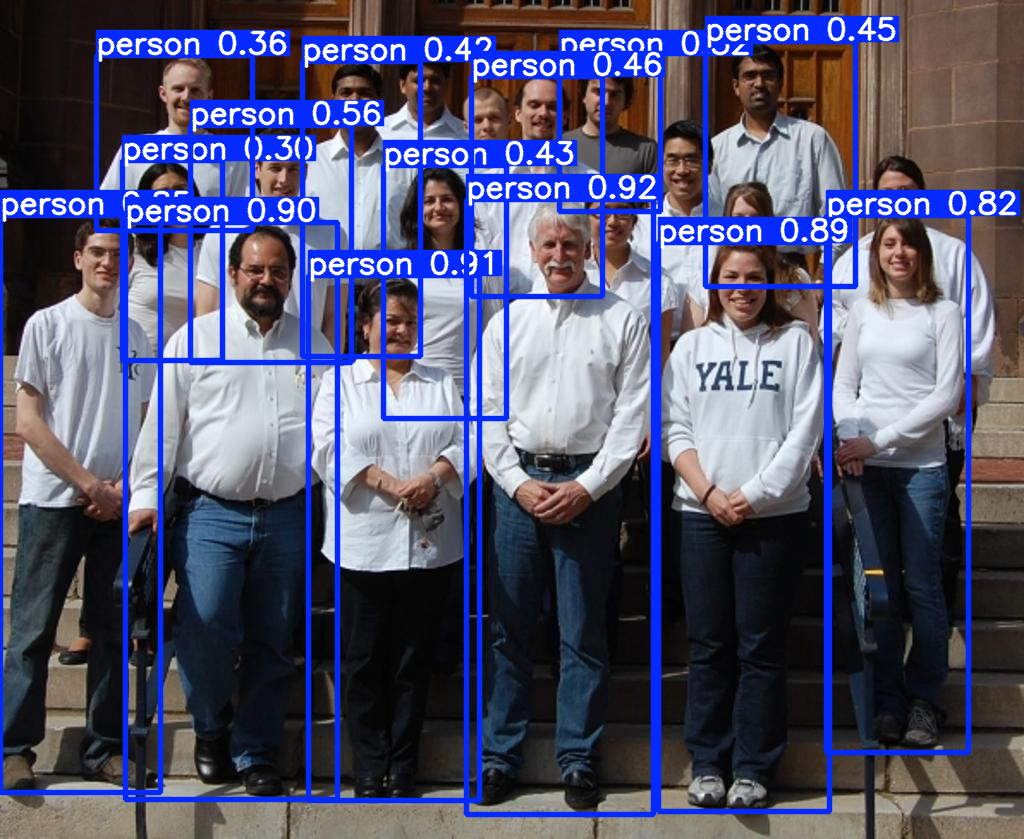

In [117]:
results = model("WIDER_test/WIDER_test/images/12--Group/12_Group_Group_12_Group_Group_12_27.jpg")
results[0].show()

# 학습 진행

In [118]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print(device)

cuda:0


In [119]:
train_results = model.train(
    data="data.yaml",  # dataset 인식하는 .yaml파일 경로
    epochs=20,  # 학습 횟수
    imgsz=640,  # 학습하는 이미지 사이즈 설정
    device=device, # 학습 디바이스 설정
    workers=4, #
    project='runs/train', # 학습 결과 저장 경로
    # name='exp',
    exist_ok=True,  # 이미 존재하는 디렉토리 덮어쓰기
    save=True # 학습한 가중치를 모델로써 저장
)

New https://pypi.org/project/ultralytics/8.3.81 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.78 🚀 Python-3.10.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX A5000, 24241MiB)
engine/trainer: task=detect, mode=train, model=yolo11n.pt, data=data.yaml, epochs=20, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=cuda:0, workers=4, project=runs/train, name=train, exist_ok=True, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=Fa

train: Scanning /home/20190891/dataset/train... 5260 images, 2 backgrounds, 0 corrupt: 100%|██████████| 5260/5260 [02:29<00:00, 35.19it/s]

train: WARNING ⚠️ /home/20190891/dataset/train/data_3231.jpg: 1 duplicate labels removed


train: New cache created: /home/20190891/dataset/train.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Scanning /home/20190891/dataset/val... 3226 images, 0 backgrounds, 1 corrupt: 100%|██████████| 3226/3226 [01:26<00:00, 37.21it/s]

val: WARNING ⚠️ /home/20190891/dataset/val/data_1060.jpg: 1 duplicate labels removed
val: WARNING ⚠️ /home/20190891/dataset/val/data_1885.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [      1.002]


val: New cache created: /home/20190891/dataset/val.cache
Plotting labels to runs/train/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)


2025/03/01 18:21:06 INFO mlflow.bedrock: Enabled auto-tracing for Bedrock. Note that MLflow can only trace boto3 service clients that are created after this call. If you have already created one, please recreate the client by calling `boto3.client`.
2025/03/01 18:21:06 INFO mlflow.tracking.fluent: Autologging successfully enabled for boto3.
2025/03/01 18:21:08 INFO mlflow.tracking.fluent: Autologging successfully enabled for statsmodels.


MLflow: logging run_id(762b35db4ab347dc98eed39c052c4bce) to http://127.0.0.1:5000
MLflow: disable with 'yolo settings mlflow=False'
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 1 dataloader workers
Logging results to runs/train/train
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20     0.658G       2.44      2.092      1.397        541        640: 100%|██████████| 329/329 [08:56<00:00,  1.63s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 101/101 [03:15<00:00,  1.94s/it]


                   all       3225      39675      0.618      0.326       0.36      0.165

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20      11.4G      1.957      1.287        1.1        357        640: 100%|██████████| 329/329 [04:56<00:00,  1.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 101/101 [01:14<00:00,  1.36it/s]


                   all       3225      39675       0.71      0.397      0.456      0.228

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20      10.3G      1.871      1.169      1.068        394        640: 100%|██████████| 329/329 [04:21<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 101/101 [01:12<00:00,  1.39it/s]


                   all       3225      39675      0.726      0.426      0.481      0.234

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20      10.8G       1.82      1.093      1.052        392        640: 100%|██████████| 329/329 [04:16<00:00,  1.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 101/101 [01:13<00:00,  1.37it/s]


                   all       3225      39675      0.746      0.444      0.504      0.253

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20      11.4G      1.759      1.034      1.039        490        640: 100%|██████████| 329/329 [05:21<00:00,  1.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 101/101 [02:24<00:00,  1.44s/it]


                   all       3225      39675      0.761      0.442      0.514      0.256

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20      12.9G      1.745      1.009      1.034        184        640: 100%|██████████| 329/329 [03:49<00:00,  1.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 101/101 [08:28<00:00,  5.03s/it]


                   all       3225      39675       0.76      0.449      0.525      0.263

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20        13G      1.725     0.9918      1.026        448        640: 100%|██████████| 329/329 [09:06<00:00,  1.66s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 101/101 [03:55<00:00,  2.33s/it]


                   all       3225      39675      0.767      0.469      0.543      0.275

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20      15.1G      1.701     0.9565      1.017        260        640: 100%|██████████| 329/329 [03:58<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 101/101 [01:09<00:00,  1.45it/s]


                   all       3225      39675      0.773       0.47      0.538      0.272

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20      13.5G      1.684     0.9419      1.013        488        640: 100%|██████████| 329/329 [03:39<00:00,  1.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 101/101 [01:09<00:00,  1.45it/s]


                   all       3225      39675       0.77      0.477      0.543       0.28

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20      10.3G      1.673     0.9268      1.011        304        640: 100%|██████████| 329/329 [03:40<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 101/101 [01:09<00:00,  1.46it/s]


                   all       3225      39675       0.78      0.483      0.553      0.279
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20      13.9G      1.623     0.9036      1.008        272        640: 100%|██████████| 329/329 [03:32<00:00,  1.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 101/101 [01:09<00:00,  1.45it/s]


                   all       3225      39675      0.776      0.489      0.561      0.287

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20      8.77G      1.605     0.8695      1.005        170        640: 100%|██████████| 329/329 [03:30<00:00,  1.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 101/101 [01:09<00:00,  1.45it/s]


                   all       3225      39675       0.78      0.494      0.567      0.289

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20      14.8G      1.606     0.8631      1.003        218        640: 100%|██████████| 329/329 [03:28<00:00,  1.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 101/101 [01:09<00:00,  1.46it/s]


                   all       3225      39675      0.789      0.493      0.568      0.295

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20      12.5G       1.59     0.8397     0.9977        129        640: 100%|██████████| 329/329 [03:44<00:00,  1.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 101/101 [01:09<00:00,  1.46it/s]


                   all       3225      39675      0.791      0.505      0.575      0.297

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20      11.2G      1.577     0.8289     0.9968         79        640: 100%|██████████| 329/329 [03:19<00:00,  1.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 101/101 [01:10<00:00,  1.44it/s]


                   all       3225      39675       0.79      0.499      0.573      0.298

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20      13.4G      1.555     0.8138     0.9911         40        640: 100%|██████████| 329/329 [03:29<00:00,  1.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 101/101 [01:09<00:00,  1.46it/s]


                   all       3225      39675      0.797      0.509      0.583      0.304

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20      18.5G      1.541      0.796     0.9856        123        640: 100%|██████████| 329/329 [03:29<00:00,  1.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 101/101 [01:07<00:00,  1.49it/s]


                   all       3225      39675      0.791      0.515      0.586      0.308

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20      11.3G      1.547      0.799     0.9839        338        640: 100%|██████████| 329/329 [03:30<00:00,  1.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 101/101 [01:09<00:00,  1.46it/s]


                   all       3225      39675      0.794      0.512      0.586      0.307

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20      9.06G      1.533     0.7863     0.9774        160        640: 100%|██████████| 329/329 [03:34<00:00,  1.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 101/101 [01:17<00:00,  1.30it/s]


                   all       3225      39675      0.801      0.517      0.591      0.312

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20      16.1G      1.526     0.7786     0.9752        173        640: 100%|██████████| 329/329 [03:21<00:00,  1.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 101/101 [01:17<00:00,  1.31it/s]


                   all       3225      39675      0.802      0.519      0.592      0.312

20 epochs completed in 2.122 hours.
Optimizer stripped from runs/train/train/weights/last.pt, 5.4MB
Optimizer stripped from runs/train/train/weights/best.pt, 5.4MB

Validating runs/train/train/weights/best.pt...
Ultralytics 8.3.78 🚀 Python-3.10.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX A5000, 24241MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 101/101 [01:14<00:00,  1.36it/s]


                   all       3225      39675      0.801      0.519      0.592      0.312
Speed: 0.1ms preprocess, 0.9ms inference, 0.0ms loss, 1.9ms postprocess per image
Results saved to runs/train/train
🏃 View run train at: http://127.0.0.1:5000/#/experiments/304833543303463077/runs/762b35db4ab347dc98eed39c052c4bce
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/304833543303463077
MLflow: results logged to http://127.0.0.1:5000
MLflow: disable with 'yolo settings mlflow=False'


# 학습 이후 모델 시각화


image 1/1 /home/20190891/WIDER_test/WIDER_test/images/12--Group/12_Group_Group_12_Group_Group_12_27.jpg: 544x640 20 faces, 193.5ms
Speed: 4.2ms preprocess, 193.5ms inference, 2.1ms postprocess per image at shape (1, 3, 544, 640)


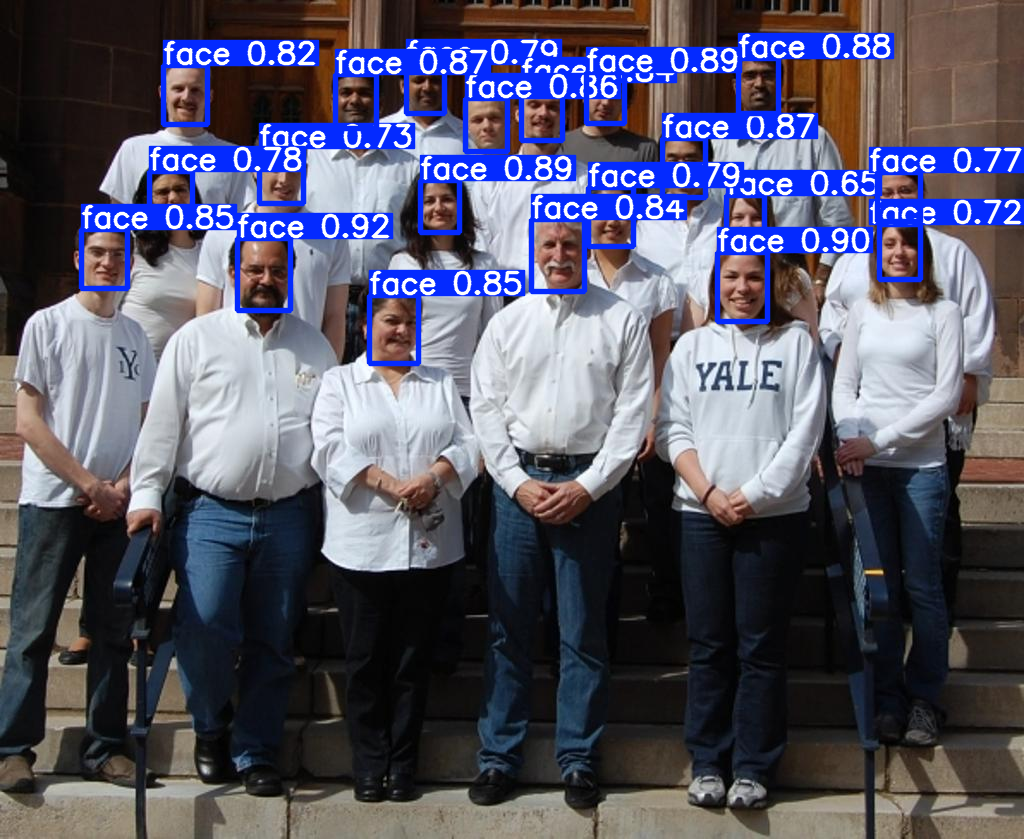

In [120]:
# 학습 이전 모델에서 랜덤 추출한 사진을 학습한 모델로 다시 시각화
model_trained = YOLO("runs/train/exp/weights/best.pt")
results = model_trained("WIDER_test/WIDER_test/images/12--Group/12_Group_Group_12_Group_Group_12_27.jpg")
results[0].show()

# 보고서

## 1. WIDER FACE 데이터셋

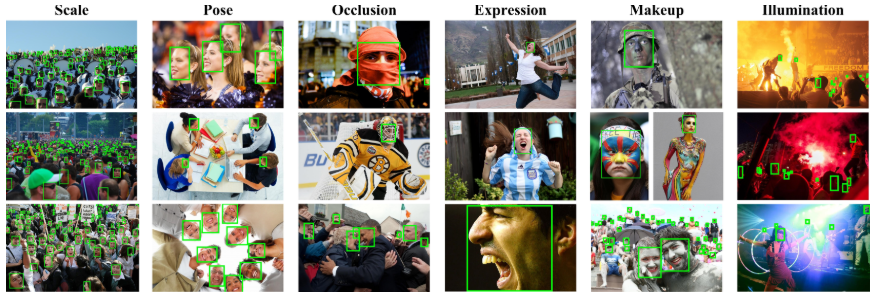

- 얼굴 검출을 위한 벤치마크 데이터셋
- 32203개의 이미지와 393703개의 얼굴 바운딩 박스가 존재한다.
- 다양한 크기, 포즈, 가려짐, 조명, 선명함, 표정 등이 annotation파일에 포함한다.
- 데이터 분할
    - train : 40%
    - validation : 10%
    - test : 50% (bbox가 공개되지 않음)
- 활용 분야
    - Object Detection : 일반적인 객체탐지 모델의 성능을 평가하는 데에 사용됨
    - Face Detection : 가려짐, 조명, 선명도 등 다양한 환경의 사진들이 포함되어 있어 강건한 얼굴 검출 모델의 성능을 평가하는 데에 사용됨
    


## 2. 데이터 전처리

### 2-1. 파일 구조 차이

- 기존 WIDERFACE데이터셋은 images 디렉토리 안에 소주제를 포함하는 디렉토리가 존재하고 그 안에 이미지파일이 존재함
- 또한 모든 bbox값을 포함하는 txt파일 하나로 존재함

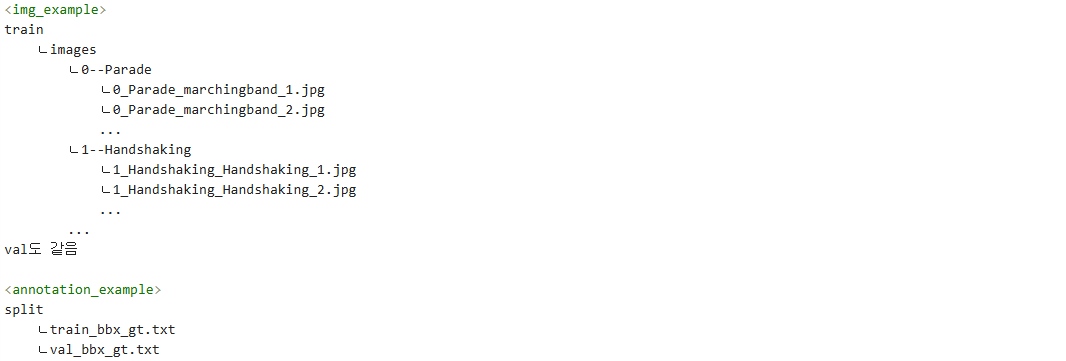

- 하지만 YOLO모델에 들어가는 데이터셋 양식은 데이터 경로 안에 images, labels디렉토리가 있고 그 안에 이미지와 label.txt파일이 각각 일대일 대응되어 저장되어있음
- 또한 images, labels를 나누지 않고, 한 디렉토리 내에 넣어도 되기 때문에 이 실험의 경우엔 이러한 방식으로 데이터 디렉토리를 설정했음

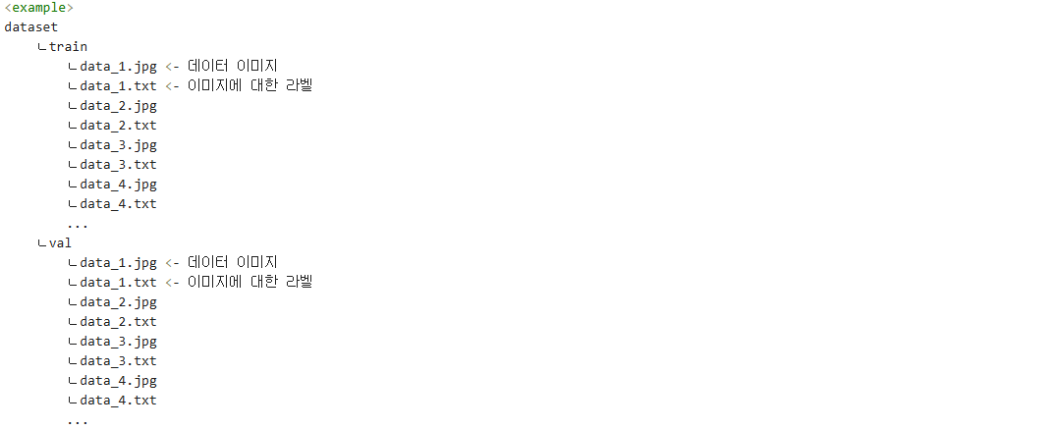


### 2-2. annotation파일 format의 차이

- 기존 WIDERFACE의 annotation파일은 파일 디렉토리, 얼굴 개수, 얼굴의 bbox와 다양한 정보를 나열한 형식으로 이루어있음
- bbox의 형식은 <x y 너비 높이 (흐림, 가려짐 등 정보)>인데 중요한 x, y, 너비, 높이가 픽셀값으로 이루어져있다.
- 또한 x, y값은 bbox의 왼쪽 위의 꼭지점의 좌표이다.

<WIDERFACE형식 annotaion>

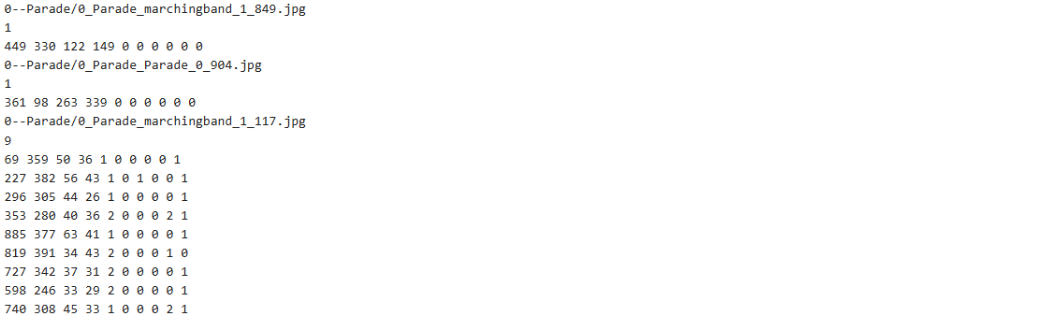

- 반면 YOLO의 bbox양식은 <클래스index x y 너비 높이>이다.
- 우선 과제에서는 얼굴만 검출하기 때문에, 클래스index는 0으로 고정한다.
- 하지만 WIDERFACE와 달리 x, y, 너비, 높이가 픽셀값에서 이미지 전체 너비, 높이로 나눈 상대픽셀값으로 이루어져있다.
- 또한 x, y값은 bbox의 중심점의 상대픽셀값으로 이루어져있다는 점이 다르다.

<YOLO형식 annotation>

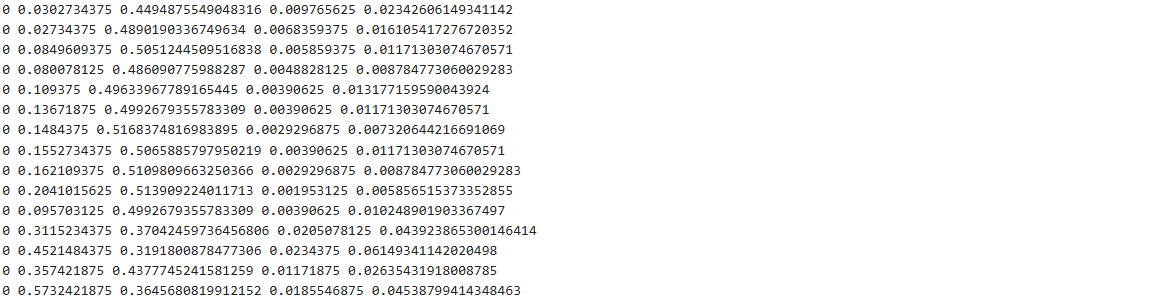



### 2-3. .yaml파일을 통해 모델에 데이터 입력

- ultralytics의 YOLO모델을 학습시키는 함수 안에는 학습에 필요한 정보들이 들어가있는 .yaml파일을 넣어주어야 한다.
- .yaml파일에 들어가는 요소
    - train : train dataset경로
    - val : val dataset경로
    - nc : 클래스 개수
    - names : 클래스 이름
- 직접 파일을 만들어 넣어주었다.

<data.yaml>

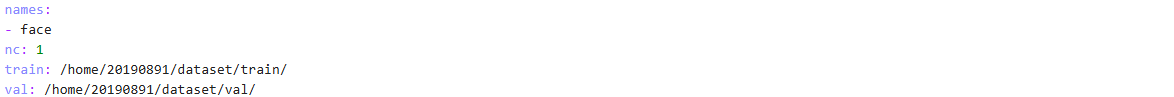

## 3. 학습결과 분석 및 고찰

- 학습하지 않은 YOLO모델은 사람, 깃발 등의 객체 전체를 인식하고 있지만, 데이터셋 학습을 통해 얼굴만을 인식하는 모델을 만들었다. 예시 사진을 통해 얼굴만 잘 인식하는 것을 볼 수 있다.

- precision, recall, mAP50, mAP50-95의 값이 지속적으로 상승하다 precision 정확도 80%에 수렴하는 모습을 보여주며 학습이 잘 진행되는 모습을 보여주었다.

- 하지만 학습 도중 정확도가 6%p정도 떨어지는 등 안정성 측면에서 떨어지기 때문에 learning rate, early stopping등 다양한 하이퍼파라미터 튜닝을 통해 안정적으로 학습이 진행되도록 할 필요성이 있다.